In [1]:
import pandas as pd # Manejo de bases de datos
import geopandas as gpd # Manejo de bases de datos geográficas
import numpy as np # Funciones numéricas
import matplotlib.pyplot as plt # Gráficas
import seaborn as sns # Gráficas
import datetime as dt
import folium
import unicodedata

from geopandas.tools import sjoin
from unicodedata import normalize

from kmodes.kprototypes import KPrototypes

from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.datasets import make_blobs

from branca.colormap import linear
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.cm as cm

### Execute silhoutte test for different characteristics

In [2]:
# Peak contagion dates in Bogotá
peak_dates = ['01/05/2020' ,'01/08/2020', '01/11/2020', '10/01/2021', '01/03/2021', '01/05/2021',
             '10/06/2021', '01/09/2021']

peak_dates2 = ['01-05-2020' ,'01-08-2020', '01-11-2020', '10-01-2021', '01-03-2021', '01-05-2021',
             '10-06-2021', '01-09-2021']

peak_dates3 = ['01-11-2020', '10-01-2021', '01-03-2021', '10-06-2021']

ClustDF_list = []
base_path = '/home/ubuntu/javeriana/MOTUS-PUJ/Step_2/2_ML_Preps/Test_Clustering_DF/'
# Create list with test DataFrames
for k in range(len(peak_dates3)):
    file_name = 'date_'+peak_dates3[k]+'.pkl'
    temp = pd.read_pickle(base_path+file_name, compression='gzip')
    temp = gpd.GeoDataFrame(temp)
    ClustDF_list.append(temp)
    ClustDF_list[k].crs = "EPSG:4326"
    ClustDF_list[k].to_crs(epsg=4326, inplace=True)
    del temp
    
ClustDF_list[0].head(2)

,LOCNombre,PopLoc,UTAM,LOCid,ESTRATOPre,UTAMNombre,PopDen[p/km2],geometry,N_Hosp,N_IPS,N_ITur,N_SITP,N_Ecomer,UTAM_cases01-11-2020,local_rt_01-11-2020,Total trips
0,usaquen,571268.0,1,1,1.0,PASEO DE LOS LIBERTADORES,0.010476,"POLYGON ((-74.02609 4.82311, -74.02571 4.82311...",0.0,0.000000,0.0,0.009524,0.019154,0.012342,0.512498,0.045404
1,suba,1252675.0,2,11,1.0,LA ACADEMIA,0.010225,"POLYGON ((-74.03849 4.79952, -74.04214 4.77702...",0.0,0.002703,0.0,0.057143,0.003361,0.010469,0.531852,0.079078


In [3]:
ClustDFmat_list = []
#Create list with DataFrames that will be later transformed into matrices
for i in range(len(peak_dates3)):
    ClustDFmat_list.append(ClustDF_list[i].copy())
    ClustDFmat_list[i].drop(columns={'LOCNombre', 'UTAM', 'LOCid', 'UTAMNombre', 'geometry',
                                    'PopLoc', }, inplace=True)
    
ClustDFmat_list[0].head(2)

,ESTRATOPre,PopDen[p/km2],N_Hosp,N_IPS,N_ITur,N_SITP,N_Ecomer,UTAM_cases01-11-2020,local_rt_01-11-2020,Total trips
0,1.0,0.010476,0.0,0.000000,0.0,0.009524,0.019154,0.012342,0.512498,0.045404
1,1.0,0.010225,0.0,0.002703,0.0,0.057143,0.003361,0.010469,0.531852,0.079078


In [4]:
X_list = [] #list with matrices that contain observations in different dates

for i in range(len(ClustDFmat_list)):
    X_list.append(ClustDFmat_list[i].to_numpy())

For n_clusters = 2 The average silhouette_score is : 0.24422158807922484
For n_clusters = 3 The average silhouette_score is : 0.20330950171695492
For n_clusters = 4 The average silhouette_score is : 0.18827723413629607
For n_clusters = 5 The average silhouette_score is : 0.17253639471346974
For n_clusters = 6 The average silhouette_score is : 0.09962932747606111


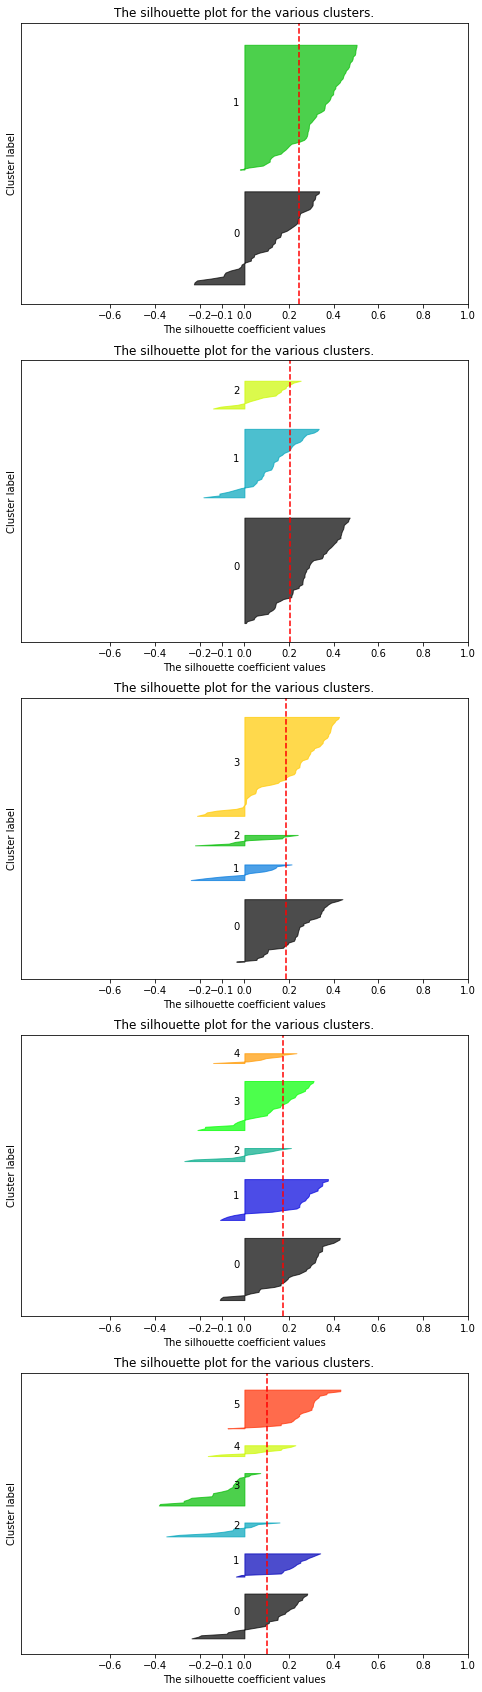

In [5]:
# Execute silhoutte test for complete characteristics Kprototype
j = 3 # Select date to examine
X = X_list[j]
range_n_clusters = [2, 3, 4, 5, 6] #Number of clusters to be trained

fig, (ax1) = plt.subplots(5, 1)
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig.set_size_inches(8, 30)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1[n_clusters-2].set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1[n_clusters-2].set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KPrototypes(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X, categorical=[0])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1[n_clusters-2].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1[n_clusters-2].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1[n_clusters-2].set_title("The silhouette plot for the various clusters.")
    ax1[n_clusters-2].set_xlabel("The silhouette coefficient values")
    ax1[n_clusters-2].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1[n_clusters-2].axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1[n_clusters-2].set_yticks([])  # Clear the yaxis labels / ticks
    ax1[n_clusters-2].set_xticks([-0.6,-0.4,-0.2,-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

fig.savefig('/home/ubuntu/javeriana/MOTUS-PUJ/Step_2/2_ML_Preps/Outputs/Complete_KProt_'+peak_dates3[j]+'.png')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.19874743601315012
For n_clusters = 3 The average silhouette_score is : 0.15890011429888512
For n_clusters = 4 The average silhouette_score is : 0.1519648731407142
For n_clusters = 5 The average silhouette_score is : 0.14024907697918002
For n_clusters = 6 The average silhouette_score is : 0.13782419287427886


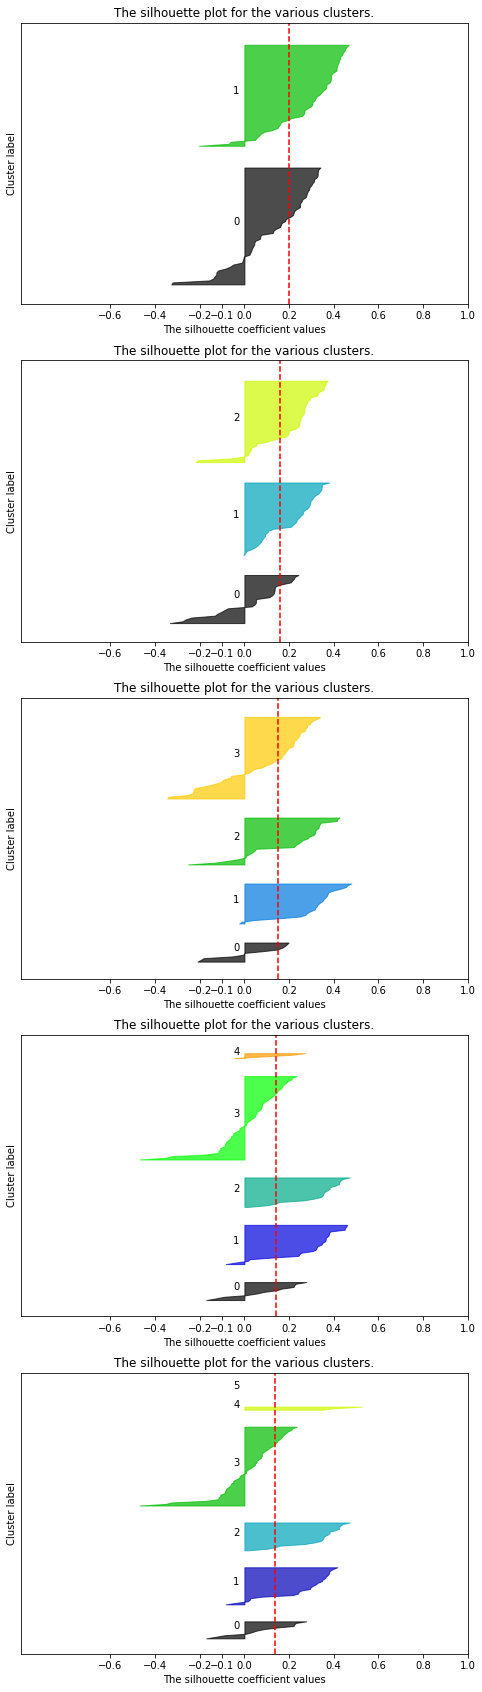

In [6]:
# Execute silhoutte test for complete characteristics GMM
j = 3 #Select date
X = X_list[j]
range_n_clusters = [2, 3, 4, 5, 6]

fig, (ax1) = plt.subplots(5, 1)
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig.set_size_inches(8, 30)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1[n_clusters-2].set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1[n_clusters-2].set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = GMM(n_components=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1[n_clusters-2].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1[n_clusters-2].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1[n_clusters-2].set_title("The silhouette plot for the various clusters.")
    ax1[n_clusters-2].set_xlabel("The silhouette coefficient values")
    ax1[n_clusters-2].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1[n_clusters-2].axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1[n_clusters-2].set_yticks([])  # Clear the yaxis labels / ticks
    ax1[n_clusters-2].set_xticks([-0.6,-0.4,-0.2,-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

fig.savefig('/home/ubuntu/javeriana/MOTUS-PUJ/Step_2/2_ML_Preps/Outputs/Complete_GMM_'+peak_dates3[j]+'.png')
plt.show()

In [7]:
# Execute silhoutte test for partial characteristics Kprototype
ClustDFmat_list2 = ClustDFmat_list.copy()
# Drop cols to construct matrices
for i in range(len(peak_dates3)):
    ClustDFmat_list2[i].drop(columns={'ESTRATOPre', 'PopDen[p/km2]', 'N_Hosp', 'N_IPS', 'N_ITur', 
                                      'N_SITP', 'N_Ecomer', 'Total trips'}, inplace=True)

In [8]:
ClustDFmat_list2[0].head(3)

,UTAM_cases01-11-2020,local_rt_01-11-2020
0,0.012342,0.512498
1,0.010469,0.531852
2,0.005311,0.519951


In [9]:
X_list = [] #DataFrame list
# Create numpy matrices
for i in range(len(ClustDFmat_list2)):
    X_list.append(ClustDFmat_list2[i].to_numpy())

For n_clusters = 2 The average silhouette_score is : 0.4946173218951734
For n_clusters = 3 The average silhouette_score is : 0.363902360293377
For n_clusters = 4 The average silhouette_score is : 0.36835558916851635
For n_clusters = 5 The average silhouette_score is : 0.3764311161839524
For n_clusters = 6 The average silhouette_score is : 0.3819356042504403


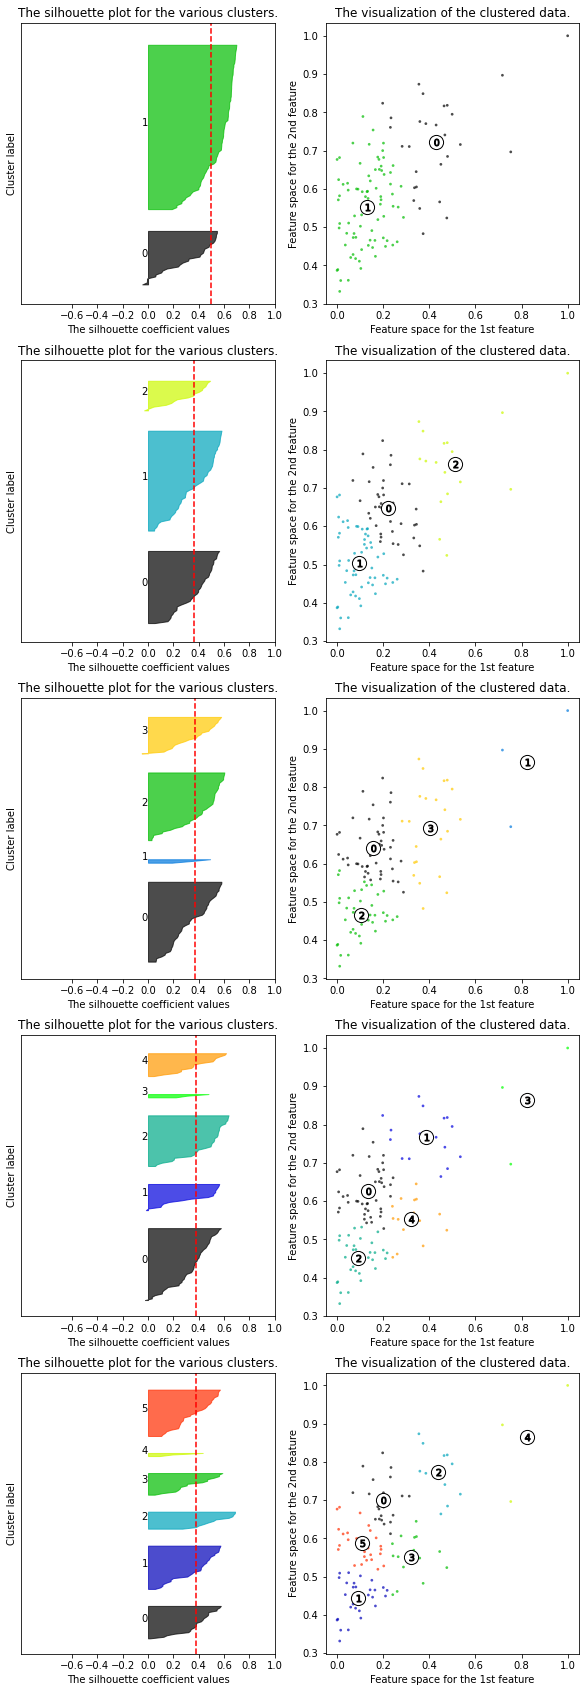

In [10]:
j = 3 #Select date
X = X_list[j]
range_n_clusters = [2, 3, 4, 5, 6]
fig, (ax1) = plt.subplots(5, 2)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig.set_size_inches(10, 30)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1[n_clusters-2][0].set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1[n_clusters-2][0].set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1[n_clusters-2][0].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1[n_clusters-2][0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1[n_clusters-2][0].set_title("The silhouette plot for the various clusters.")
    ax1[n_clusters-2][0].set_xlabel("The silhouette coefficient values")
    ax1[n_clusters-2][0].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1[n_clusters-2][0].axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1[n_clusters-2][0].set_yticks([])  # Clear the yaxis labels / ticks
    ax1[n_clusters-2][0].set_xticks([-0.6,-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax1[n_clusters-2][1].scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax1[n_clusters-2][1].scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax1[n_clusters-2][1].scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax1[n_clusters-2][1].set_title("The visualization of the clustered data.")
    ax1[n_clusters-2][1].set_xlabel("Feature space for the 1st feature")
    ax1[n_clusters-2][1].set_ylabel("Feature space for the 2nd feature")
    
fig.savefig('/home/ubuntu/javeriana/MOTUS-PUJ/Step_2/2_ML_Preps/Outputs/Binary_KMeans_'+peak_dates3[j]+'.png')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.5056748397880559
For n_clusters = 3 The average silhouette_score is : 0.3095922884384344
For n_clusters = 4 The average silhouette_score is : 0.32572570907039883
For n_clusters = 5 The average silhouette_score is : 0.314404041809003
For n_clusters = 6 The average silhouette_score is : 0.285384174005307


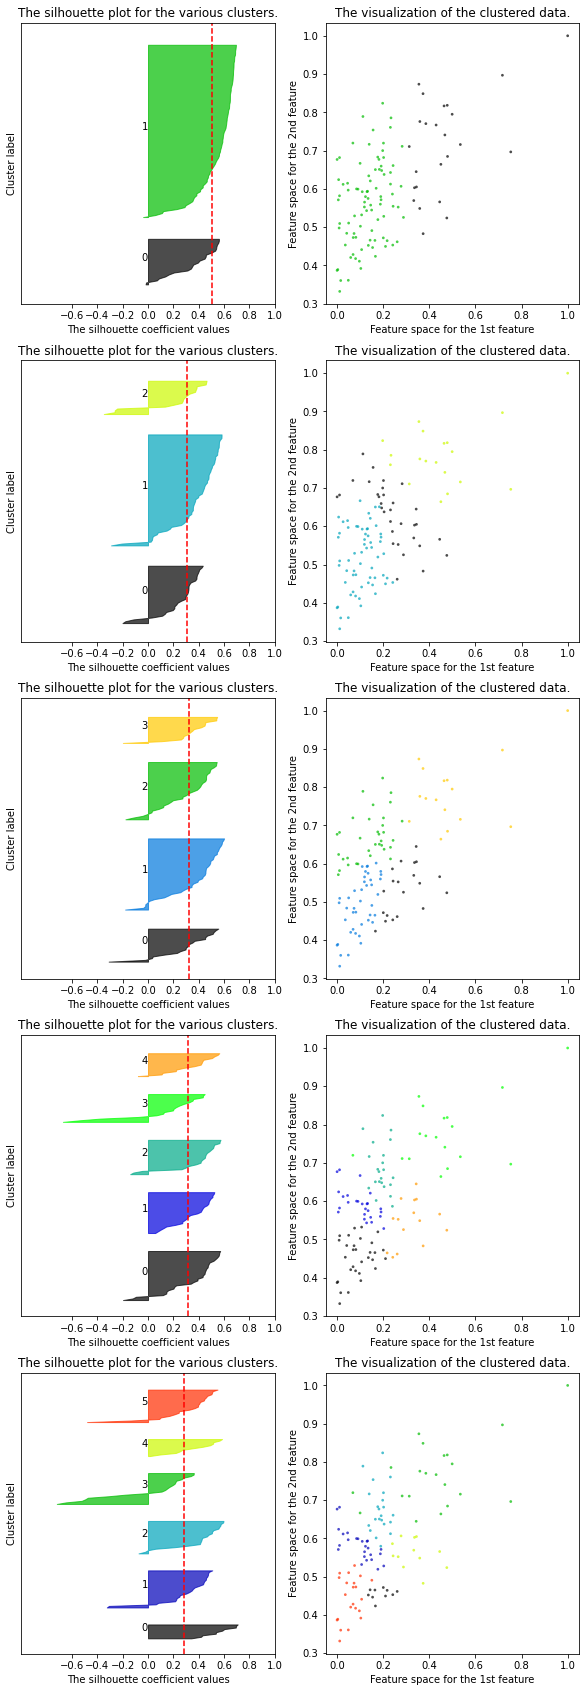

In [11]:
j = 3 # Select date
X = X_list[j]
range_n_clusters = [2, 3, 4, 5, 6]
fig, (ax1) = plt.subplots(5, 2)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig.set_size_inches(10, 30)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1[n_clusters-2][0].set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1[n_clusters-2][0].set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = GMM(n_components=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1[n_clusters-2][0].fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1[n_clusters-2][0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1[n_clusters-2][0].set_title("The silhouette plot for the various clusters.")
    ax1[n_clusters-2][0].set_xlabel("The silhouette coefficient values")
    ax1[n_clusters-2][0].set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1[n_clusters-2][0].axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1[n_clusters-2][0].set_yticks([])  # Clear the yaxis labels / ticks
    ax1[n_clusters-2][0].set_xticks([-0.6,-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax1[n_clusters-2][1].scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    #centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    #ax1[n_clusters-2][1].scatter(centers[:, 0], centers[:, 1], marker='o',
                #c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
        #ax1[n_clusters-2][1].scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    #s=50, edgecolor='k')

    ax1[n_clusters-2][1].set_title("The visualization of the clustered data.")
    ax1[n_clusters-2][1].set_xlabel("Feature space for the 1st feature")
    ax1[n_clusters-2][1].set_ylabel("Feature space for the 2nd feature")
    
fig.savefig('/home/ubuntu/javeriana/MOTUS-PUJ/Step_2/2_ML_Preps/Outputs/Binary_GMM_'+peak_dates3[j]+'.png')
plt.show()